In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [3]:
import pickle
def read_h5():
    lst = []
    with open("X and Y Dataset/x_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/x_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    return lst
def read_properties():
    lst = None
    with open('X and Y Dataset/properties.pickle','rb+') as fd:
        lst = pickle.load(fd)
    return lst
x_train,y_train,x_test,y_test = read_h5()

In [4]:
x_train

array([[-0.013259, -0.096782, -0.130589, ..., -0.135169,  0.122678,
         0.962112],
       [ 0.116003,  0.127935,  0.255208, ..., -0.215388, -0.327122,
         1.042331],
       [ 0.199526,  0.255208, -0.214112, ..., -0.135169,  0.446419,
         1.388992],
       ...,
       [ 1.211427,  1.189527,  1.199747, ...,  0.388914,  0.3805  ,
         0.397328],
       [ 1.199747,  1.199747,  1.211427, ...,  0.388914,  0.3805  ,
         0.3805  ],
       [ 1.205587,  1.199747,  1.199747, ...,  0.405741,  0.420466,
         0.412052]], dtype=float32)

In [5]:
TIME_PERIODS = 80
num_time_periods, num_sensors,num_classes,input_shape = read_properties()


In [23]:

def create_model(BATCH_SIZE = 400,EPOCHS = 50):
    print("\n--- Create neural network model="+str(BATCH_SIZE)+":"+str(EPOCHS)+" ---\n")
    # 1D CNN neural network
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    model.add(Conv1D(10, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
    model.add(Conv1D(10, 10, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(16, 10, activation='relu'))
    model.add(Conv1D(16, 10, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    print(model.summary())
    
    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
    ]
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model.fit(x_train,
                          y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_split=0.2,
                          verbose=1)
    
    score = model.evaluate(x_test, y_test, verbose=1)
    print("\nAccuracy on test data: %0.2f" % score[1])
    print("\nLoss on test data: %0.2f" % score[0])
    return history.history,score,model

# Accuracy on training data: 99%
# Accuracy on test data: 91%


--- Create neural network model=2:2 ---

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 71, 10)            310       
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 11, 16)            1616      
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_aver

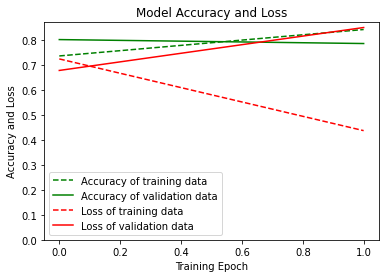


--- Create neural network model=52:2 ---

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

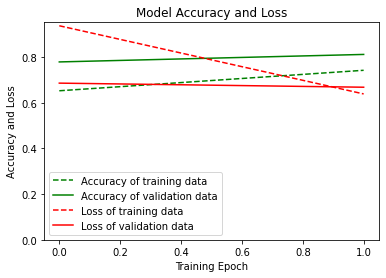


--- Create neural network model=102:2 ---

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

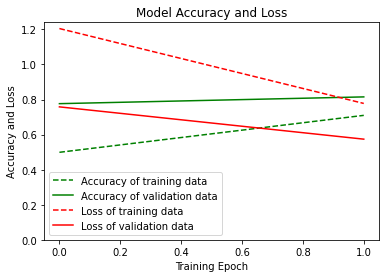


--- Create neural network model=152:2 ---

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

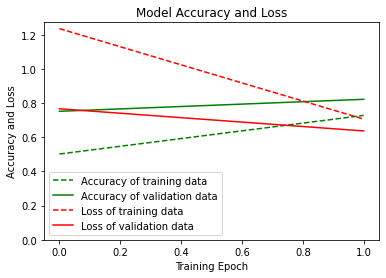


--- Create neural network model=202:2 ---

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_29 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

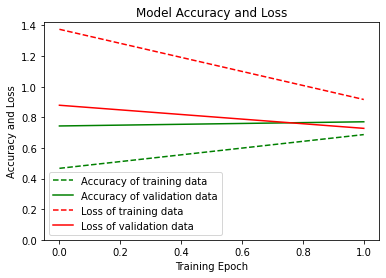


--- Create neural network model=252:2 ---

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

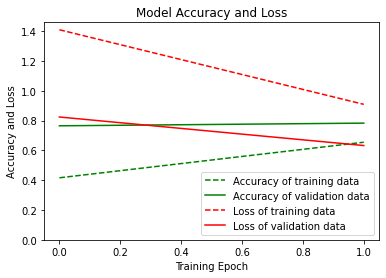


--- Create neural network model=302:2 ---

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_31 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

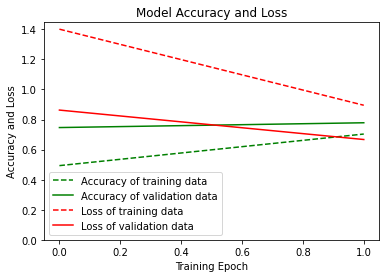


--- Create neural network model=352:2 ---

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_32 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

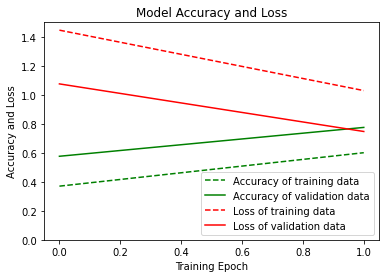


--- Create neural network model=402:2 ---

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_33 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_132 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

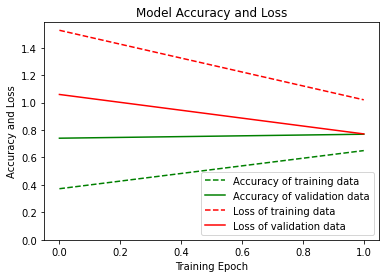


--- Create neural network model=452:2 ---

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_34 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

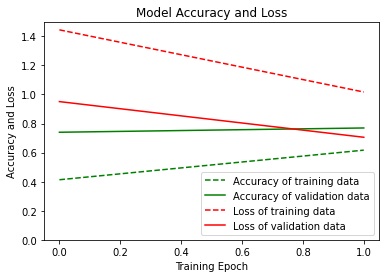


--- Create neural network model=2:22 ---

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_35 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_138 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

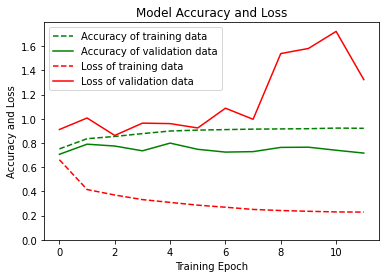


--- Create neural network model=52:22 ---

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_36 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_144 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

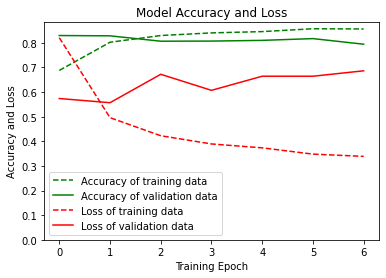


--- Create neural network model=102:22 ---

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_37 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_145 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_146 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_148 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

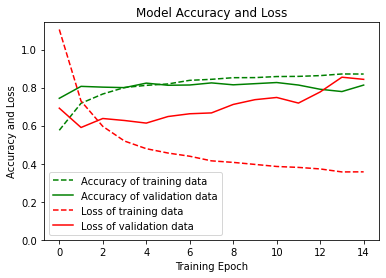


--- Create neural network model=152:22 ---

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_149 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_150 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

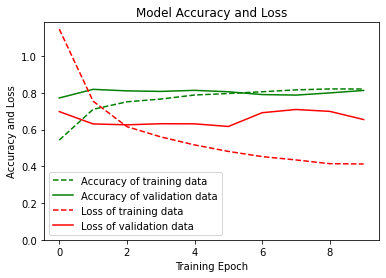


--- Create neural network model=202:22 ---

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_39 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

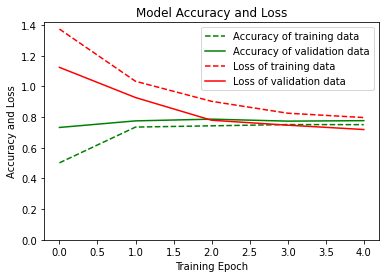


--- Create neural network model=252:22 ---

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_40 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

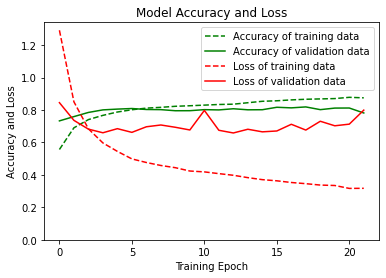


--- Create neural network model=302:22 ---

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_41 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

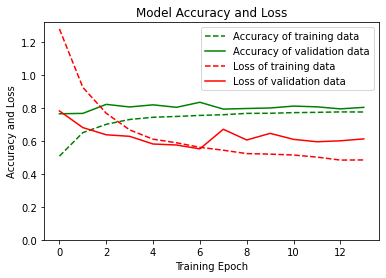


--- Create neural network model=352:22 ---

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_42 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_166 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

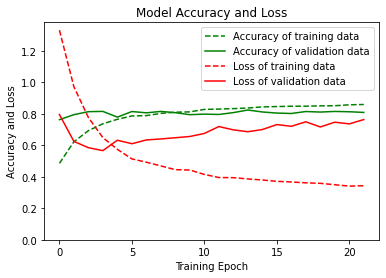


--- Create neural network model=402:22 ---

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_43 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

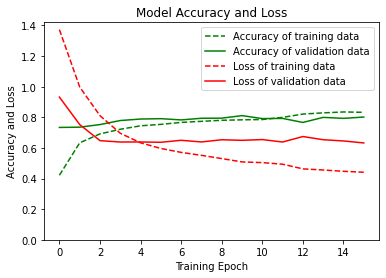


--- Create neural network model=452:22 ---

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_44 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

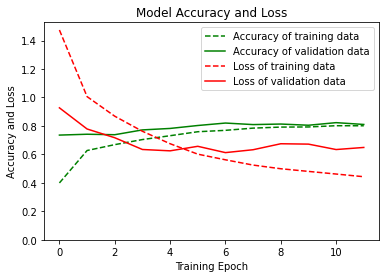


--- Create neural network model=2:42 ---

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_45 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_178 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_180 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

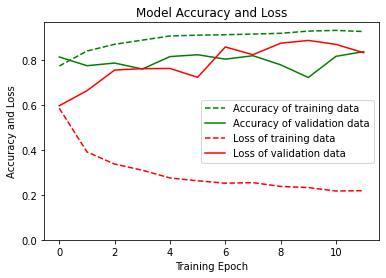


--- Create neural network model=52:42 ---

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_46 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

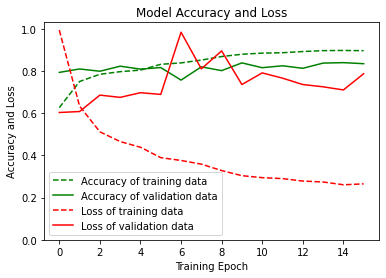


--- Create neural network model=102:42 ---

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_47 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_188 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

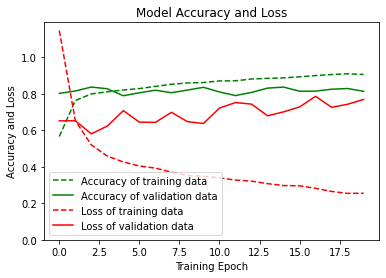


--- Create neural network model=152:42 ---

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_48 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_192 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

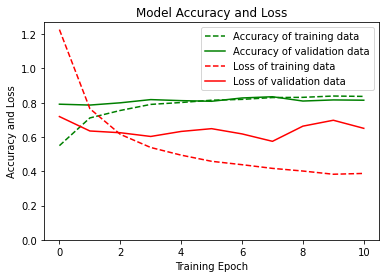


--- Create neural network model=202:42 ---

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_49 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_194 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

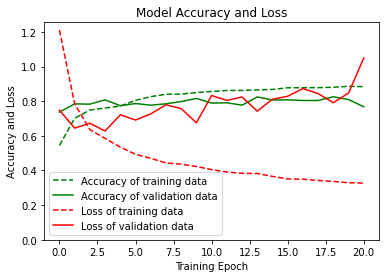


--- Create neural network model=252:42 ---

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_50 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_198 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_200 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

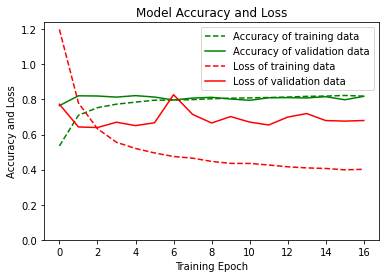


--- Create neural network model=302:42 ---

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_51 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_202 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

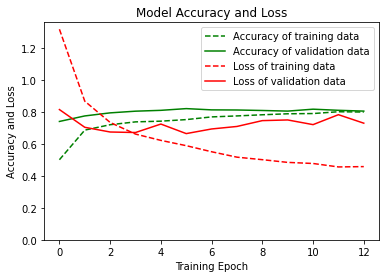


--- Create neural network model=352:42 ---

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_52 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_206 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_208 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

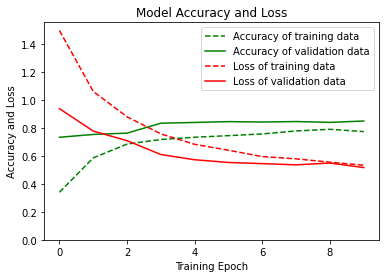


--- Create neural network model=402:42 ---

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_53 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_209 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_210 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_211 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_212 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

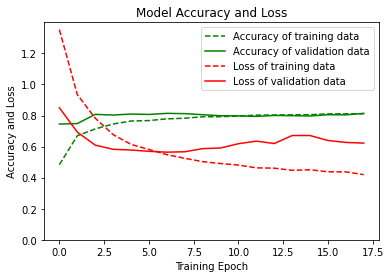


--- Create neural network model=452:42 ---

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_54 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_214 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_215 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

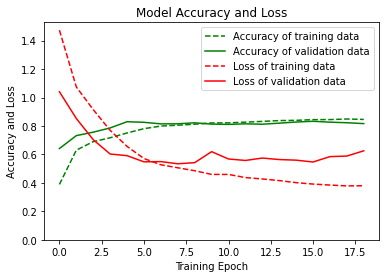


--- Create neural network model=2:62 ---

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_55 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_218 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_220 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

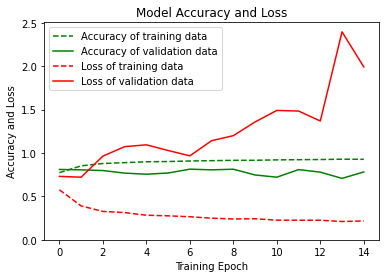


--- Create neural network model=52:62 ---

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_56 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_222 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_223 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_224 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

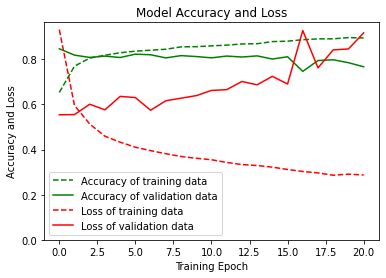


--- Create neural network model=102:62 ---

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_57 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_226 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_227 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_228 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

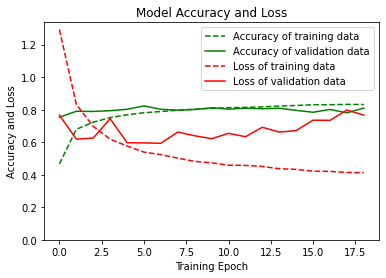


--- Create neural network model=152:62 ---

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_58 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_229 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_230 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_232 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

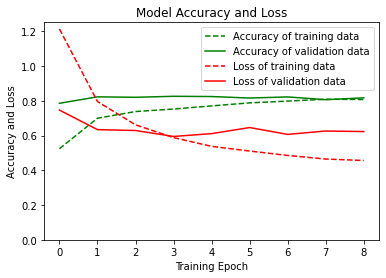


--- Create neural network model=202:62 ---

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_59 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_234 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_235 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_236 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

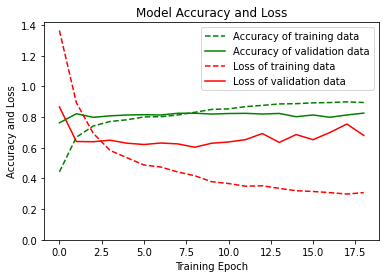


--- Create neural network model=252:62 ---

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_60 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_237 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_238 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_240 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

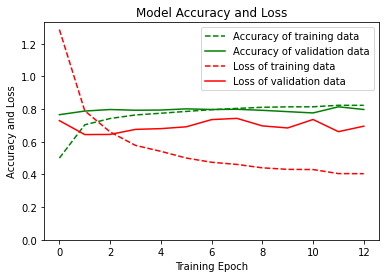


--- Create neural network model=302:62 ---

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_61 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_242 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_243 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_244 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

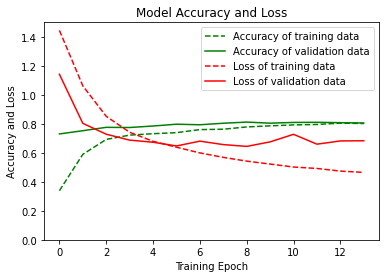


--- Create neural network model=352:62 ---

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_62 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_245 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_246 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_247 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_248 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

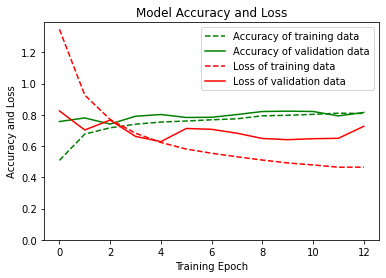


--- Create neural network model=402:62 ---

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_63 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_250 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_251 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_252 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

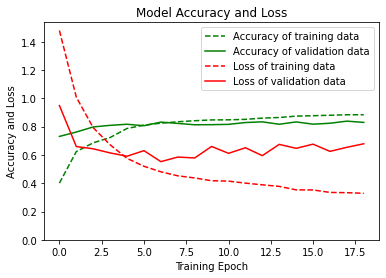


--- Create neural network model=452:62 ---

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_64 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_254 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_256 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

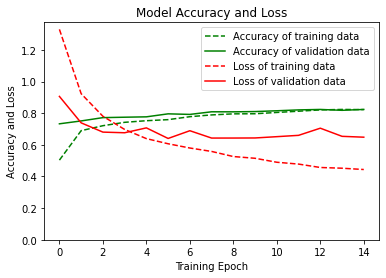


--- Create neural network model=2:82 ---

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_65 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_257 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_258 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_259 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_260 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

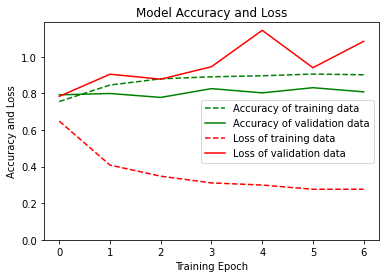


--- Create neural network model=52:82 ---

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_66 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_262 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_263 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_264 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

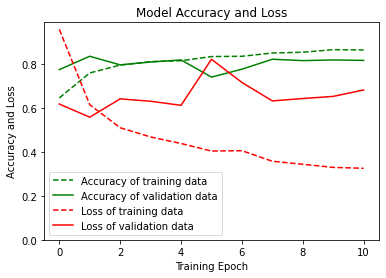


--- Create neural network model=102:82 ---

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_67 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_266 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_268 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

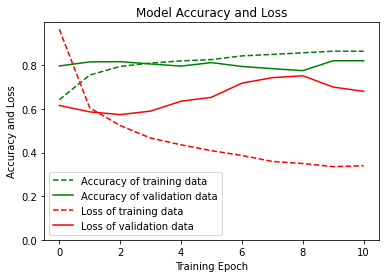


--- Create neural network model=152:82 ---

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_68 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_269 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_270 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_271 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_272 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

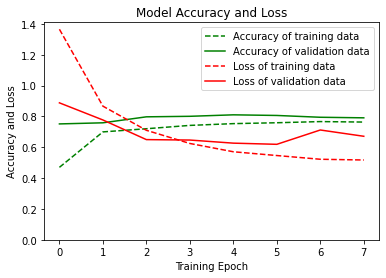


--- Create neural network model=202:82 ---

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_69 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_274 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_276 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

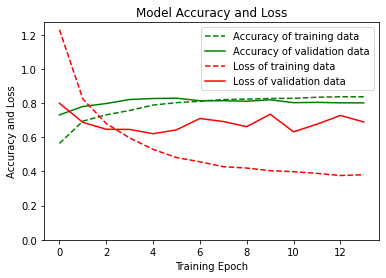


--- Create neural network model=252:82 ---

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_70 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_278 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_279 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_280 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

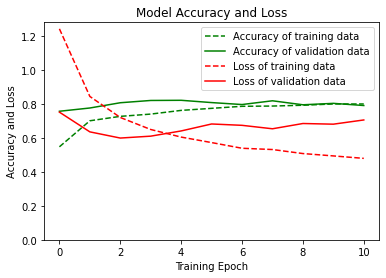


--- Create neural network model=302:82 ---

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_71 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_282 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_283 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_284 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

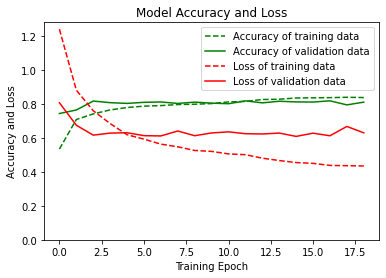


--- Create neural network model=352:82 ---

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_72 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_285 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_286 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_72 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_288 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

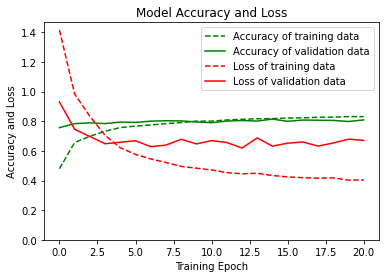


--- Create neural network model=402:82 ---

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_73 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_290 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_291 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_292 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

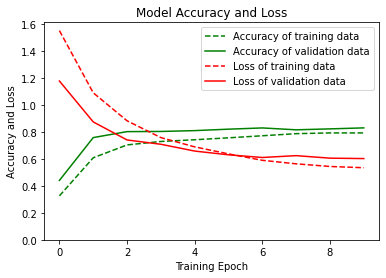


--- Create neural network model=452:82 ---

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_74 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_294 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_74 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_295 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_296 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

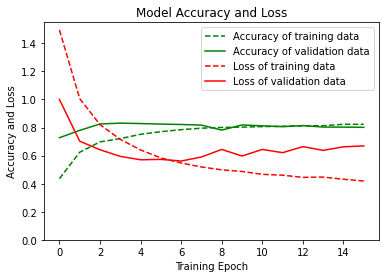

In [36]:
model_acc = []
for e in range(2,100,20):
    for b in range(2,500,50):
        history,score,model= create_model(b,e)
        print("\nAccuracy on train data: %0.2f" % (history["accuracy"][-1]))
        model_acc.append([e,b,score[1],score[0],history["accuracy"][-1],model])
        plt.figure(figsize=(6, 4))
        plt.plot(history['accuracy'], "g--", label="Accuracy of training data")
        plt.plot(history['val_accuracy'], "g", label="Accuracy of validation data")
        plt.plot(history['loss'], "r--", label="Loss of training data")
        plt.plot(history['val_loss'], "r", label="Loss of validation data")
        plt.title('Model Accuracy and Loss')
        plt.ylabel('Accuracy and Loss')
        plt.xlabel('Training Epoch')
        plt.ylim(0)
        plt.legend()
        plt.show()

In [37]:
import pickle
with open('EpochVSBatchData.p','wb') as fp:
    pickle.dump(model_acc,fp)

In [38]:
df_lol = pd.DataFrame(model_acc)
df_lol.columns=['Epoch','BatchSize','TestAcc','TestLoss','TrainAcc','model']

In [40]:
df_lol

Epoch  BatchSize   TestAcc  TestLoss  TrainAcc  \
0       2          2  0.832169  0.650640  0.842458   
1       2         52  0.823512  0.573324  0.742003   
2       2        102  0.777795  0.576712  0.709716   
3       2        152  0.788275  0.606842  0.728585   
4       2        202  0.761087  0.652758  0.687073   
5       2        252  0.738609  0.728291  0.654307   
6       2        302  0.766555  0.725576  0.703606   
7       2        352  0.716434  0.737458  0.600994   
8       2        402  0.703524  0.852059  0.649994   
9       2        452  0.699423  0.811031  0.616868   
10     22          2  0.883505  0.760387  0.921049   
11     22         52  0.852066  0.480753  0.856356   
12     22        102  0.879556  0.634480  0.871211   
13     22        152  0.845838  0.483121  0.821253   
14     22        202  0.758961  0.669394  0.750509   
15     22        252  0.861786  0.531845  0.874865   
16     22        302  0.825942  0.486422  0.777225   
17     22        352  0.861786  0.544597  0.859950   
18     22        402  0.821689  0.538120  0.832575   
19     22        452  0.824119  0.530947  0.801126   
20     42          2  0.893378  0.631984  0.925303   
21     42         52  0.897631  0.570225  0.895831   
22     42        102  0.889277  0.513108  0.906194   
23     42        152  0.867710  0.510365  0.837067   
24     42        202  0.858748  0.529659  0.883970   
25     42        252  0.848117  0.528480  0.818617   
26     42        302  0.833536  0.501791  0.798071   
27     42        352  0.819107  0.491907  0.774650   
28     42        402  0.833991  0.485622  0.810710   
29     42        452  0.866191  0.463547  0.846052   
30     62          2  0.882442  1.671428  0.927219   
31     62         52  0.869532  0.517289  0.894393   
32     62        102  0.852066  0.567762  0.831556   
33     62        152  0.839004  0.500154  0.807056   
34     62        202  0.896112  0.481297  0.895591   
35     62        252  0.828827  0.454706  0.822751   
36     62        302  0.833232  0.498932  0.801965   
37     62        352  0.825182  0.624176  0.808734   
38     62        402  0.881835  0.497318  0.883671   
39     62        452  0.859812  0.509584  0.822631   
40     82          2  0.886999  0.674100  0.902240   
41     82         52  0.849028  0.559598  0.862466   
42     82        102  0.852977  0.518770  0.864622   
43     82        152  0.823815  0.479921  0.763568   
44     82        202  0.828068  0.521741  0.837487   
45     82        252  0.819714  0.527528  0.798490   
46     82        302  0.830043  0.480448  0.837666   
47     82        352  0.830043  0.508390  0.830897   
48     82        402  0.835662  0.462826  0.792860   
49     82        452  0.827612  0.482398  0.823110   

                                                model  
0   <keras.engine.sequential.Sequential object at ...  
1   <keras.engine.sequential.Sequential object at ...  
2   <keras.engine.sequential.Sequential object at ...  
3   <keras.engine.sequential.Sequential object at ...  
4   <keras.engine.sequential.Sequential object at ...  
5   <keras.engine.sequential.Sequential object at ...  
6   <keras.engine.sequential.Sequential object at ...  
7   <keras.engine.sequential.Sequential object at ...  
8   <keras.engine.sequential.Sequential object at ...  
9   <keras.engine.sequential.Sequential object at ...  
10  <keras.engine.sequential.Sequential object at ...  
11  <keras.engine.sequential.Sequential object at ...  
12  <keras.engine.sequential.Sequential object at ...  
13  <keras.engine.sequential.Sequential object at ...  
14  <keras.engine.sequential.Sequential object at ...  
15  <keras.engine.sequential.Sequential object at ...  
16  <keras.engine.sequential.Sequential object at ...  
17  <keras.engine.sequential.Sequential object at ...  
18  <keras.engine.sequential.Sequential object at ...  
19  <keras.engine.sequential.Sequential object at ...  
20  <keras.engine.sequential.Sequential object at ...  
21  <keras.engine

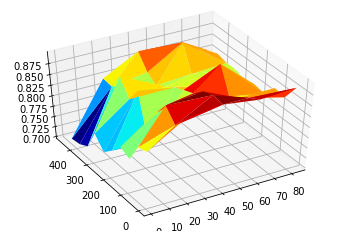

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_lol["Epoch"], df_lol["BatchSize"], df_lol["TestAcc"], cmap=plt.cm.jet, linewidth=0.2)
ax.view_init(45, 240)
plt.show()




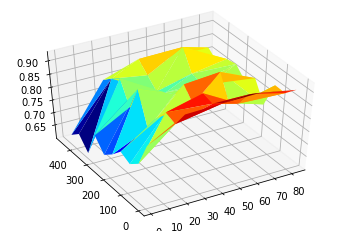

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_lol["Epoch"], df_lol["BatchSize"], df_lol["TrainAcc"], cmap=plt.cm.jet, linewidth=0.2)
ax.view_init(45, 240)
plt.show()





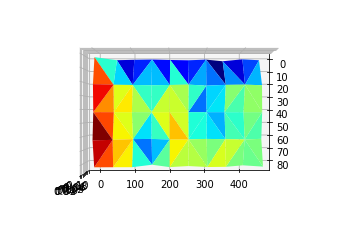

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_lol["Epoch"], df_lol["BatchSize"], df_lol["TrainAcc"]-df_lol["TestAcc"], cmap=plt.cm.jet, linewidth=0.2)
ax.view_init(90, 0)
plt.show()







--- Create neural network model=2:2 ---

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_75 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_297 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_298 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_75 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_299 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_300 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_aver

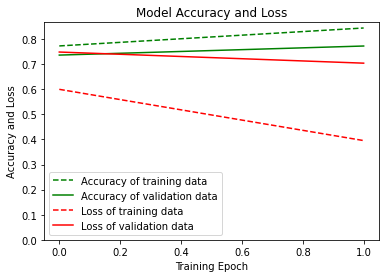


--- Create neural network model=12:2 ---

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_76 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_302 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_303 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_304 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

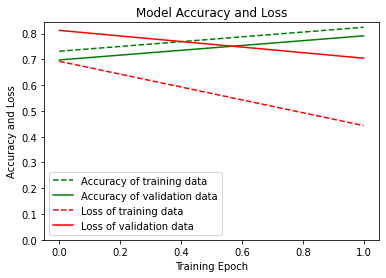


--- Create neural network model=22:2 ---

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_77 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_305 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_306 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_307 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_308 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

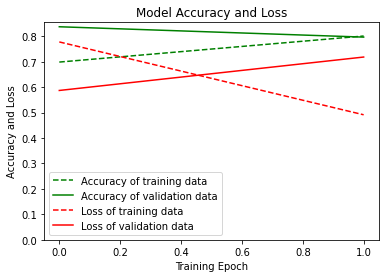


--- Create neural network model=32:2 ---

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_78 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_310 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_311 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_312 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

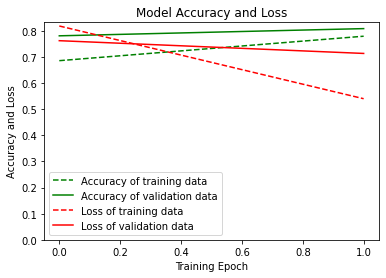


--- Create neural network model=42:2 ---

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_79 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_313 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_314 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_315 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_316 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

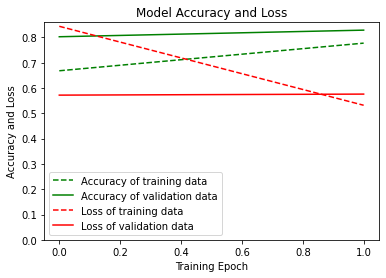


--- Create neural network model=52:2 ---

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_80 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_317 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_318 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_319 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_320 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

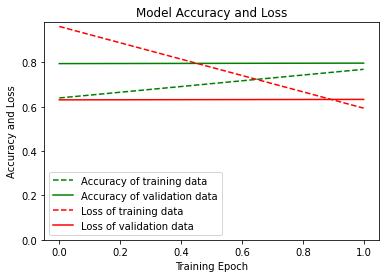


--- Create neural network model=62:2 ---

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_81 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_321 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_322 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_323 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_324 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

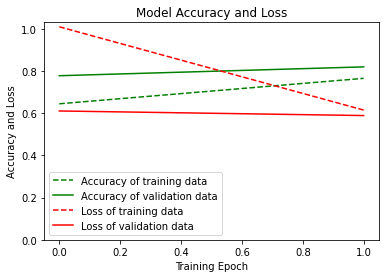


--- Create neural network model=72:2 ---

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_82 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_325 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_326 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_327 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_328 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

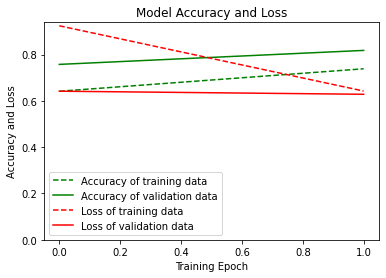


--- Create neural network model=82:2 ---

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_83 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_329 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_330 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_331 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_332 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

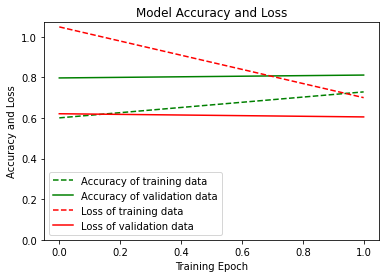


--- Create neural network model=92:2 ---

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_84 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_334 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_335 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_336 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

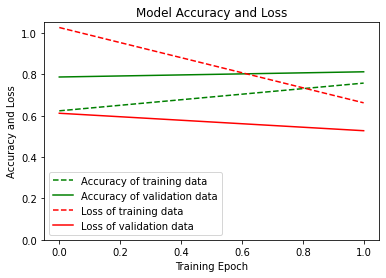


--- Create neural network model=2:22 ---

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_85 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_337 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_338 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_85 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_340 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

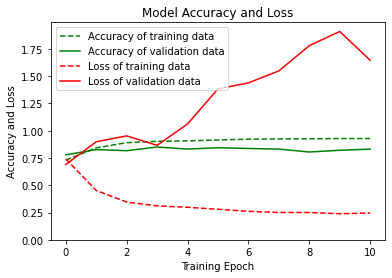


--- Create neural network model=12:22 ---

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_86 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_341 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_342 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_343 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_344 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

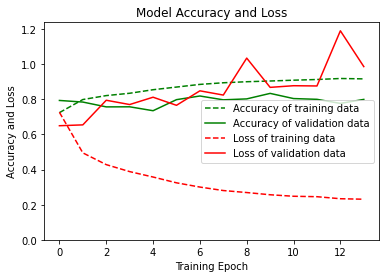


--- Create neural network model=22:22 ---

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_87 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_345 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_346 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_87 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_347 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_348 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

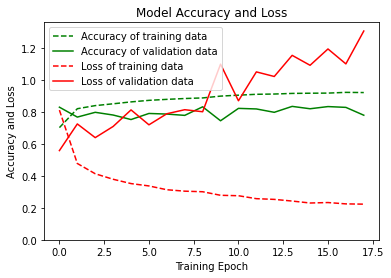


--- Create neural network model=32:22 ---

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_88 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_349 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_350 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_88 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_351 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_352 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

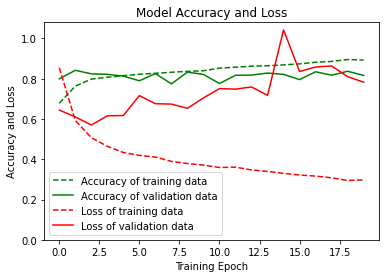


--- Create neural network model=42:22 ---

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_89 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_353 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_354 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_89 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_355 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_356 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

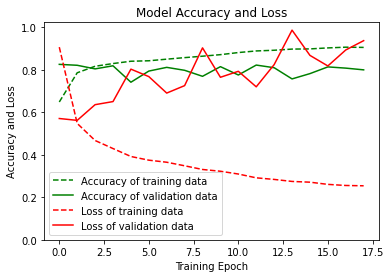


--- Create neural network model=52:22 ---

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_90 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_357 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_358 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_90 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_359 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_360 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

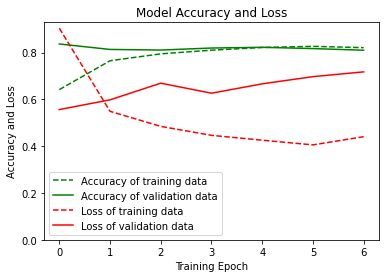


--- Create neural network model=62:22 ---

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_91 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_361 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_362 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_91 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_363 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_364 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

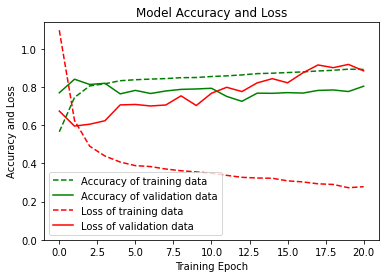


--- Create neural network model=72:22 ---

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_92 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_365 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_366 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_367 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_368 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

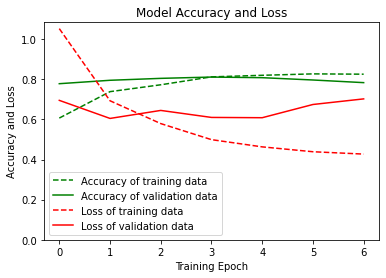


--- Create neural network model=82:22 ---

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_93 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_369 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_370 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_93 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_371 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_372 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

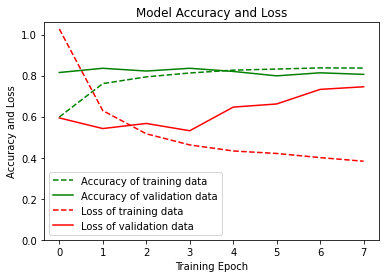


--- Create neural network model=92:22 ---

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_94 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_373 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_374 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_375 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_376 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

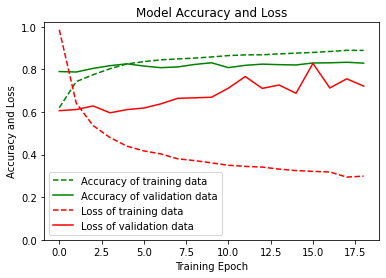


--- Create neural network model=2:42 ---

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_95 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_377 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_378 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_95 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_379 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_380 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_ave

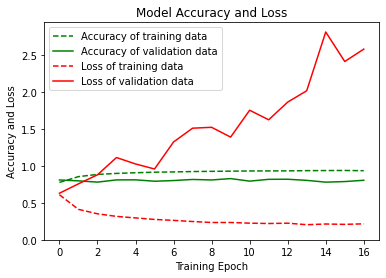


--- Create neural network model=12:42 ---

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_96 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_381 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_382 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_96 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_383 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_384 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

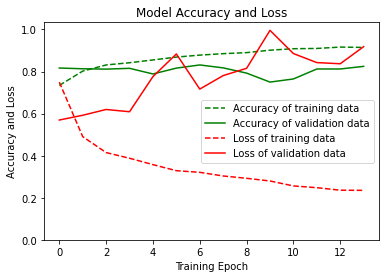


--- Create neural network model=22:42 ---

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_97 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_385 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_386 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_97 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_387 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_388 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

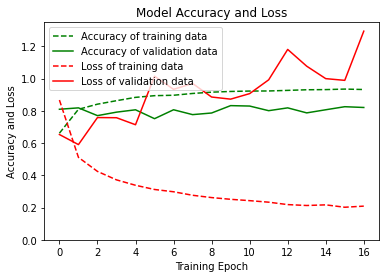


--- Create neural network model=32:42 ---

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_98 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_389 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_390 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_98 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_391 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_392 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

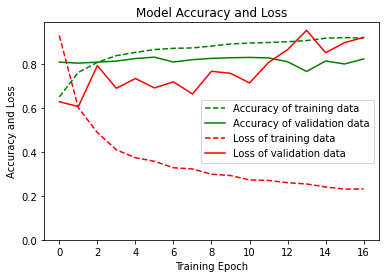


--- Create neural network model=42:42 ---

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_99 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_393 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_394 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_99 (MaxPooling (None, 20, 10)            0         
_________________________________________________________________
conv1d_395 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_396 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

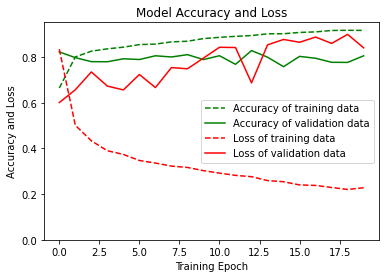


--- Create neural network model=52:42 ---

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_100 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_397 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_398 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_399 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_400 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

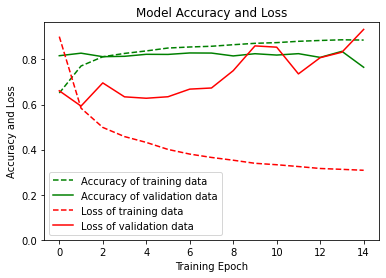


--- Create neural network model=62:42 ---

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_101 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_401 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_402 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_101 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_403 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_404 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

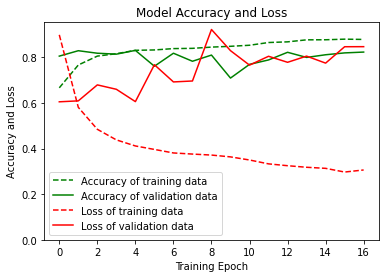


--- Create neural network model=72:42 ---

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_102 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_405 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_406 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_102 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_407 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_408 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

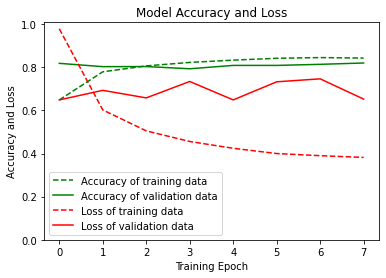


--- Create neural network model=82:42 ---

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_103 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_409 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_410 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_103 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_411 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_412 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

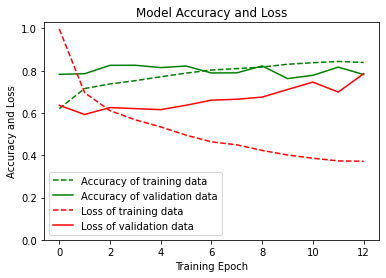


--- Create neural network model=92:42 ---

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_104 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_413 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_414 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_104 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_415 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_416 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

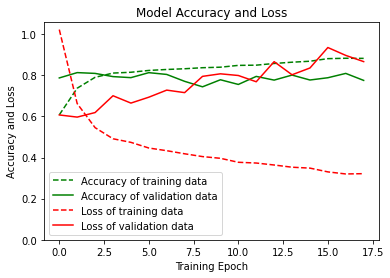


--- Create neural network model=2:62 ---

Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_105 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_417 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_418 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_419 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_420 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

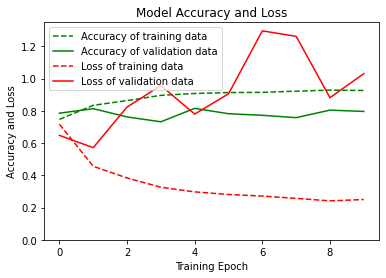


--- Create neural network model=12:62 ---

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_106 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_421 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_422 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_106 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_423 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_424 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

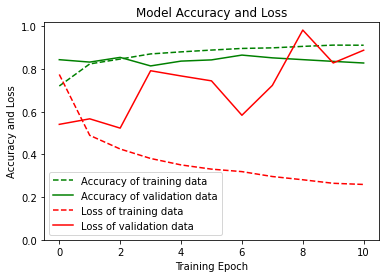


--- Create neural network model=22:62 ---

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_107 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_425 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_426 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_107 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_427 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_428 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

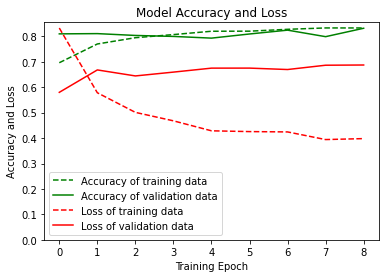


--- Create neural network model=32:62 ---

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_108 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_429 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_430 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_431 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_432 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

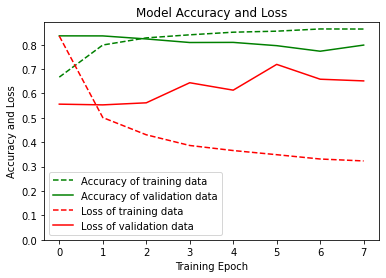


--- Create neural network model=42:62 ---

Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_109 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_433 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_434 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_109 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_435 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_436 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

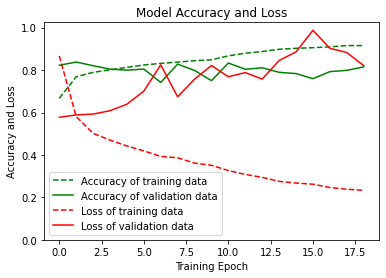


--- Create neural network model=52:62 ---

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_110 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_437 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_438 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_439 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_440 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

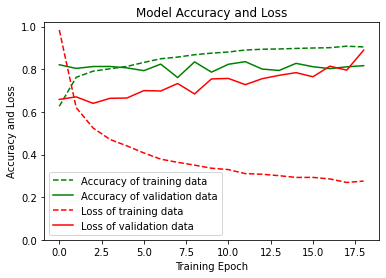


--- Create neural network model=62:62 ---

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_111 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_441 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_442 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_111 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_443 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_444 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

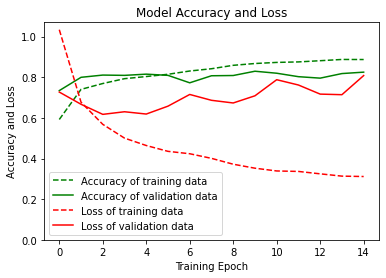


--- Create neural network model=72:62 ---

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_112 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_445 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_446 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_112 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_447 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_448 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

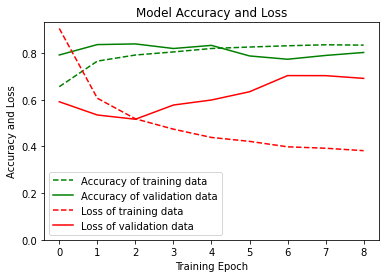


--- Create neural network model=82:62 ---

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_113 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_449 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_450 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_451 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_452 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

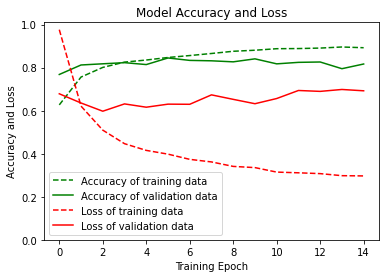


--- Create neural network model=92:62 ---

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_114 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_453 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_454 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_455 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_456 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

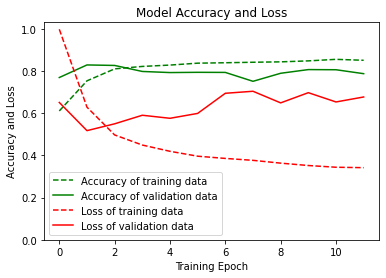


--- Create neural network model=2:82 ---

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_115 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_457 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_458 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_459 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_460 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_av

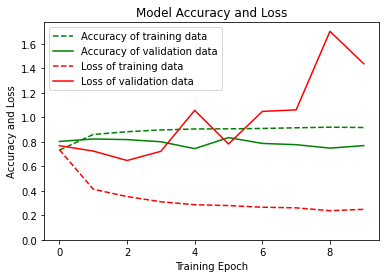


--- Create neural network model=12:82 ---

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_116 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_461 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_462 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_116 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_463 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_464 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

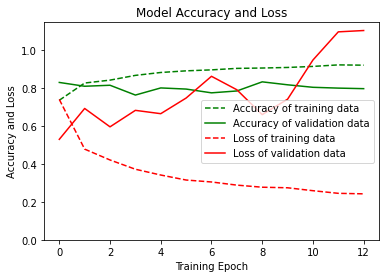


--- Create neural network model=22:82 ---

Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_117 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_465 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_466 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_117 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_467 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_468 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

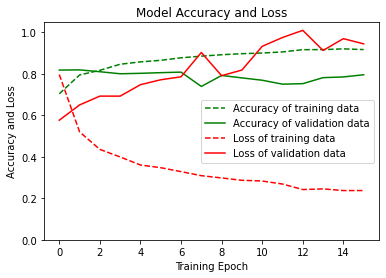


--- Create neural network model=32:82 ---

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_118 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_469 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_470 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_118 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_471 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_472 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

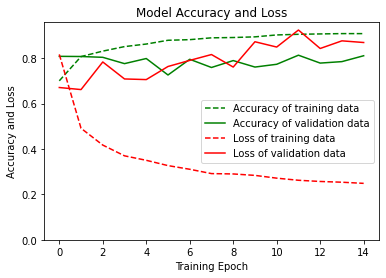


--- Create neural network model=42:82 ---

Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_119 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_473 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_474 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_119 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_475 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_476 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

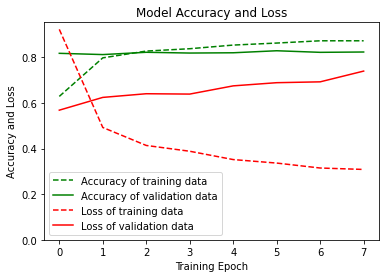


--- Create neural network model=52:82 ---

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_120 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_477 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_478 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_479 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_480 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

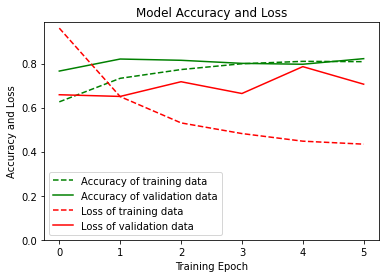


--- Create neural network model=62:82 ---

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_121 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_481 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_482 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_483 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_484 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

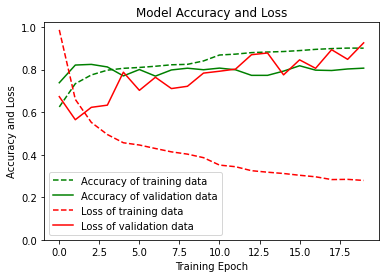


--- Create neural network model=72:82 ---

Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_122 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_485 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_486 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_487 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_488 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

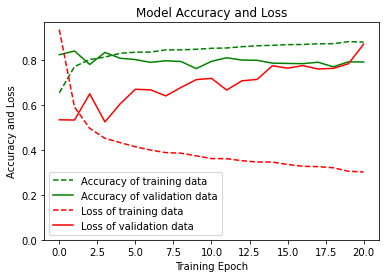


--- Create neural network model=82:82 ---

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_123 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_489 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_490 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_123 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_491 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_492 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

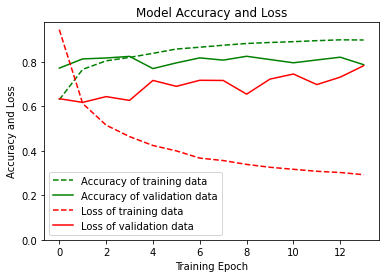


--- Create neural network model=92:82 ---

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_124 (Reshape)        (None, 80, 3)             0         
_________________________________________________________________
conv1d_493 (Conv1D)          (None, 71, 10)            310       
_________________________________________________________________
conv1d_494 (Conv1D)          (None, 62, 10)            1010      
_________________________________________________________________
max_pooling1d_124 (MaxPoolin (None, 20, 10)            0         
_________________________________________________________________
conv1d_495 (Conv1D)          (None, 11, 16)            1616      
_________________________________________________________________
conv1d_496 (Conv1D)          (None, 2, 16)             2576      
_________________________________________________________________
global_a

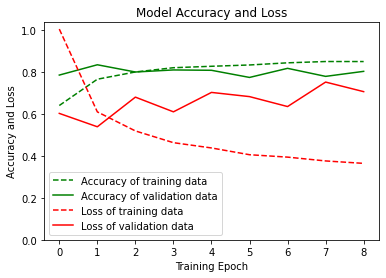

In [60]:
model_acc_tmp = []
for e in range(2,100,20):
    for b in range(2,100,10):
        history,score,model= create_model(b,e)
        print("\nAccuracy on train data: %0.2f" % (history["accuracy"][-1]))
        model_acc_tmp.append([e,b,score[1],score[0],history["accuracy"][-1],model])
        plt.figure(figsize=(6, 4))
        plt.plot(history['accuracy'], "g--", label="Accuracy of training data")
        plt.plot(history['val_accuracy'], "g", label="Accuracy of validation data")
        plt.plot(history['loss'], "r--", label="Loss of training data")
        plt.plot(history['val_loss'], "r", label="Loss of validation data")
        plt.title('Model Accuracy and Loss')
        plt.ylabel('Accuracy and Loss')
        plt.xlabel('Training Epoch')
        plt.ylim(0)
        plt.legend()
        plt.show()

In [61]:
import pickle
with open('EpochVSBatchData_zoom.p','wb') as fp:
    pickle.dump(model_acc_tmp,fp)

In [67]:
df_lol_tmp = pd.DataFrame(model_acc_tmp)
df_lol_tmp.columns=['Epoch','BatchSize','TestAcc','TestLoss','TrainAcc','model']
df_lol_tmp.head()

Epoch  BatchSize   TestAcc  TestLoss  TrainAcc  \
0      2          2  0.839459  0.561732  0.844255   
1      2         12  0.857078  0.505966  0.824608   
2      2         22  0.825030  0.564726  0.801186   
3      2         32  0.828068  0.532139  0.779022   
4      2         42  0.839763  0.500606  0.777585   

                                               model  
0  <keras.engine.sequential.Sequential object at ...  
1  <keras.engine.sequential.Sequential object at ...  
2  <keras.engine.sequential.Sequential object at ...  
3  <keras.engine.sequential.Sequential object at ...  
4  <keras.engine.sequential.Sequential object at ...

In [68]:
df_lol_tmp.max()

Epoch        82.000000
BatchSize    92.000000
TestAcc       0.907503
TestLoss      1.761061
TrainAcc      0.934587
dtype: float64

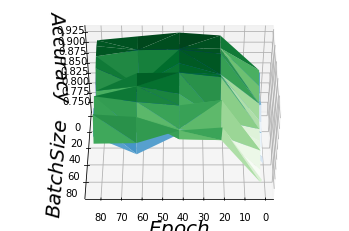

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_lol_tmp["Epoch"], df_lol_tmp["BatchSize"], df_lol_tmp["TrainAcc"], cmap=plt.cm.Greens, linewidth=0.2)
ax.plot_trisurf(df_lol_tmp["Epoch"], df_lol_tmp["BatchSize"], df_lol_tmp["TestAcc"], cmap=plt.cm.Blues, linewidth=0.2)
ax.set_xlabel('$Epoch$', fontsize=20)
ax.set_ylabel('$BatchSize$', fontsize=20)
ax.set_zlabel('$Accuracy$', fontsize=20)
ax.view_init(45, 90)
plt.show()

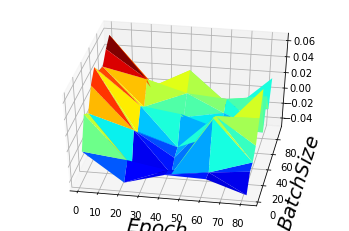

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df_lol_tmp["Epoch"], df_lol_tmp["BatchSize"],df_lol_tmp["TestAcc"]- df_lol_tmp["TrainAcc"], cmap=plt.cm.jet, linewidth=0.2)
ax.set_xlabel('$Epoch$', fontsize=20)
ax.set_ylabel('$BatchSize$', fontsize=20)
# ax.set_zlabel('$Train Accuracy$', fontsize=20)
ax.view_init(40, -80)
plt.show()

In [48]:
tmp = df_lol["TrainAcc"]-df_lol["TestAcc"]
tmp.max(),tmp.min()

(0.0447770357131958, -0.11543941497802734)

In [50]:
tmp.mean()

-0.01950313091278076


--- Learning curve of model training ---



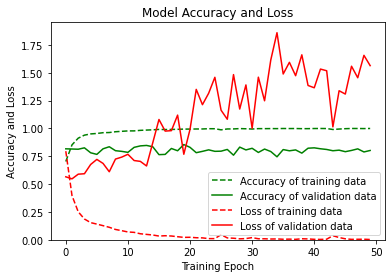

In [10]:
print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [12]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])



--- Check against test data ---

6584/6584 [==============================] - 1s 165us/step

Accuracy on test data: 0.91

Loss on test data: 0.93



--- Confusion matrix for test data ---



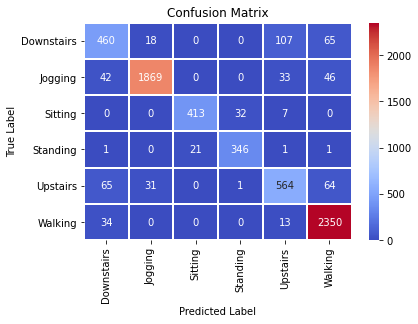

In [14]:
print("\n--- Confusion matrix for test data ---\n")
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [15]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       650
           1       0.97      0.94      0.96      1990
           2       0.95      0.91      0.93       452
           3       0.91      0.94      0.92       370
           4       0.78      0.78      0.78       725
           5       0.93      0.98      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.88      0.88      6584
weighted avg       0.91      0.91      0.91      6584




--- Create neural network model ---

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 160)               0         
_________________________________________________________________
dropout_2 (Dropo

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


16694/16694 [==============================] - 7s 439us/step - loss: 0.4841 - accuracy: 0.8221 - val_loss: 0.5990 - val_accuracy: 0.8069
Epoch 3/25
16694/16694 [==============================] - 8s 455us/step - loss: 0.3576 - accuracy: 0.8702 - val_loss: 0.5580 - val_accuracy: 0.8095
Epoch 4/25
16694/16694 [==============================] - 7s 442us/step - loss: 0.2703 - accuracy: 0.9067 - val_loss: 0.4941 - val_accuracy: 0.8275
Epoch 5/25
16694/16694 [==============================] - 7s 443us/step - loss: 0.2259 - accuracy: 0.9219 - val_loss: 0.5558 - val_accuracy: 0.8198
Epoch 6/25
16694/16694 [==============================] - 7s 445us/step - loss: 0.1970 - accuracy: 0.9326 - val_loss: 0.5841 - val_accuracy: 0.8201
Epoch 7/25
16694/16694 [==============================] - 7s 447us/step - loss: 0.1801 - accuracy: 0.9398 - val_loss: 0.5418 - val_accuracy: 0.8234
Epoch 8/25
16694/16694 [==============================] - 8s 451us/step - loss: 0.1674 - accuracy: 0.9438 - val_loss: 0.561

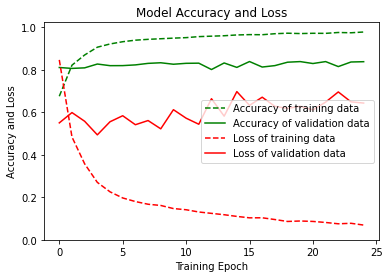

In [16]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()




--- Check against test data ---

6584/6584 [==============================] - 1s 161us/step

Accuracy on test data: 0.92

Loss on test data: 0.38

--- Confusion matrix for test data ---



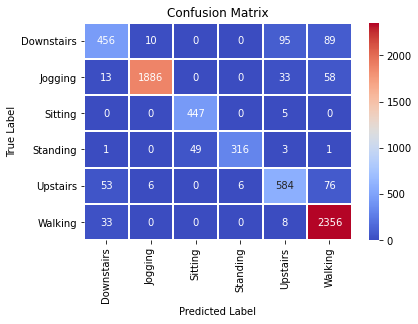

In [17]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [18]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       650
           1       0.99      0.95      0.97      1990
           2       0.90      0.99      0.94       452
           3       0.98      0.85      0.91       370
           4       0.80      0.81      0.80       725
           5       0.91      0.98      0.95      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.92      0.92      0.92      6584




--- Create neural network model ---

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 160)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense) 

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


16694/16694 [==============================] - 4s 238us/step - loss: 0.5707 - accuracy: 0.7766 - val_loss: 0.5313 - val_accuracy: 0.8146
Epoch 3/25
16694/16694 [==============================] - 4s 218us/step - loss: 0.4623 - accuracy: 0.8313 - val_loss: 0.5242 - val_accuracy: 0.8225
Epoch 4/25
16694/16694 [==============================] - 3s 203us/step - loss: 0.3995 - accuracy: 0.8567 - val_loss: 0.5159 - val_accuracy: 0.8376
Epoch 5/25
16694/16694 [==============================] - 3s 203us/step - loss: 0.3545 - accuracy: 0.8753 - val_loss: 0.5032 - val_accuracy: 0.8385
Epoch 6/25
16694/16694 [==============================] - 4s 257us/step - loss: 0.3204 - accuracy: 0.8894 - val_loss: 0.5049 - val_accuracy: 0.8328
Epoch 7/25
16694/16694 [==============================] - 4s 215us/step - loss: 0.2975 - accuracy: 0.8960 - val_loss: 0.5010 - val_accuracy: 0.8330
Epoch 8/25
16694/16694 [==============================] - 3s 187us/step - loss: 0.2737 - accuracy: 0.9060 - val_loss: 0.573

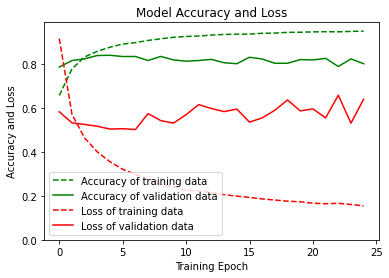

In [19]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()





--- Check against test data ---

6584/6584 [==============================] - 0s 73us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



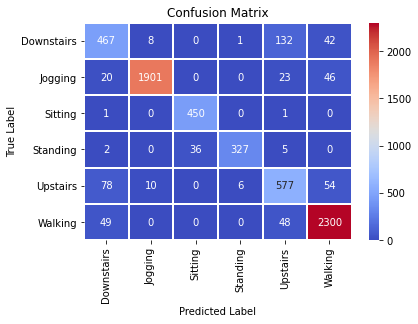


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       650
           1       0.99      0.96      0.97      1990
           2       0.93      1.00      0.96       452
           3       0.98      0.88      0.93       370
           4       0.73      0.80      0.76       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.88      0.89      6584
weighted avg       0.92      0.91      0.92      6584



In [20]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 160)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_4 (Dense) 

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


16694/16694 [==============================] - 3s 193us/step - loss: 0.5092 - accuracy: 0.8103 - val_loss: 0.5313 - val_accuracy: 0.8464
Epoch 3/25
16694/16694 [==============================] - 3s 199us/step - loss: 0.4147 - accuracy: 0.8502 - val_loss: 0.5705 - val_accuracy: 0.8165
Epoch 4/25
16694/16694 [==============================] - 4s 231us/step - loss: 0.3518 - accuracy: 0.8747 - val_loss: 0.5481 - val_accuracy: 0.8273
Epoch 5/25
16694/16694 [==============================] - 3s 204us/step - loss: 0.3047 - accuracy: 0.8933 - val_loss: 0.5174 - val_accuracy: 0.8256
Epoch 6/25
16694/16694 [==============================] - 3s 185us/step - loss: 0.2777 - accuracy: 0.9047 - val_loss: 0.5246 - val_accuracy: 0.8294
Epoch 7/25
16694/16694 [==============================] - 3s 187us/step - loss: 0.2527 - accuracy: 0.9136 - val_loss: 0.5306 - val_accuracy: 0.8287
Epoch 8/25
16694/16694 [==============================] - 3s 187us/step - loss: 0.2360 - accuracy: 0.9193 - val_loss: 0.583

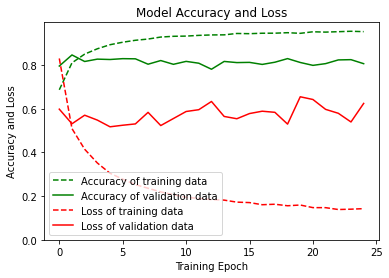

In [21]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 300
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()






--- Check against test data ---

6584/6584 [==============================] - 1s 79us/step

Accuracy on test data: 0.91

Loss on test data: 0.37

--- Confusion matrix for test data ---



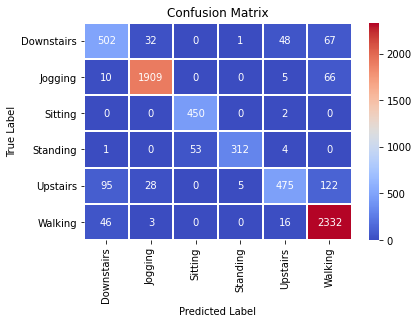


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       650
           1       0.97      0.96      0.96      1990
           2       0.89      1.00      0.94       452
           3       0.98      0.84      0.91       370
           4       0.86      0.66      0.75       725
           5       0.90      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.87      0.88      6584
weighted avg       0.91      0.91      0.91      6584



In [22]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 160)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_7 (Dense) 

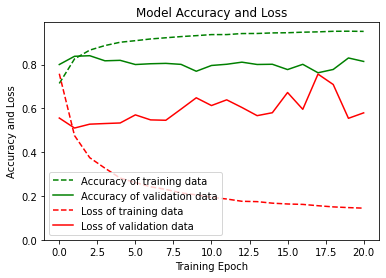

In [26]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()







--- Check against test data ---

6584/6584 [==============================] - 0s 67us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



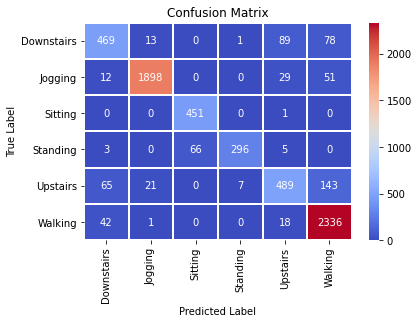


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.79      0.72      0.76       650
           1       0.98      0.95      0.97      1990
           2       0.87      1.00      0.93       452
           3       0.97      0.80      0.88       370
           4       0.77      0.67      0.72       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.90      0.90      0.90      6584



In [27]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 160)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_6 (Dense) 

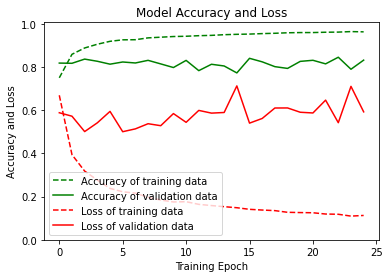

In [24]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 100
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()








--- Check against test data ---

6584/6584 [==============================] - 0s 75us/step

Accuracy on test data: 0.91

Loss on test data: 0.36

--- Confusion matrix for test data ---



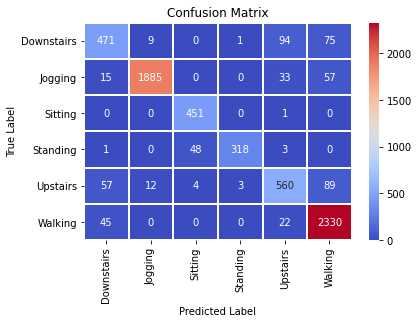


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       650
           1       0.99      0.95      0.97      1990
           2       0.90      1.00      0.94       452
           3       0.99      0.86      0.92       370
           4       0.79      0.77      0.78       725
           5       0.91      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584



In [25]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_8 ( (None, 160)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_8 (Dense) 

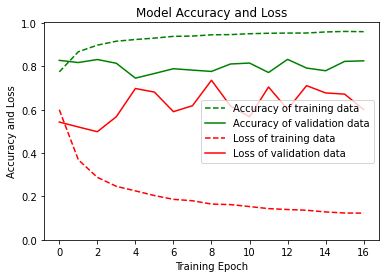

In [28]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 50
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()









--- Check against test data ---

6584/6584 [==============================] - 0s 76us/step

Accuracy on test data: 0.92

Loss on test data: 0.34

--- Confusion matrix for test data ---



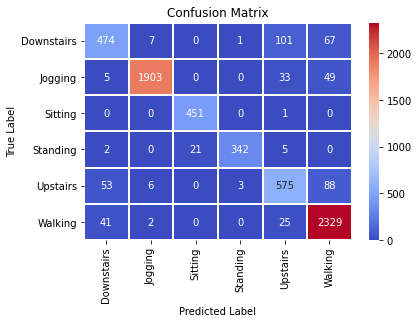


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       650
           1       0.99      0.96      0.97      1990
           2       0.96      1.00      0.98       452
           3       0.99      0.92      0.96       370
           4       0.78      0.79      0.78       725
           5       0.92      0.97      0.94      2397

    accuracy                           0.92      6584
   macro avg       0.91      0.90      0.90      6584
weighted avg       0.92      0.92      0.92      6584



In [29]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_9 ( (None, 160)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_9 (Dense) 

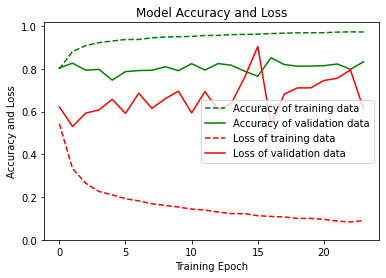

In [30]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()










--- Check against test data ---

6584/6584 [==============================] - 1s 79us/step

Accuracy on test data: 0.93

Loss on test data: 0.38

--- Confusion matrix for test data ---



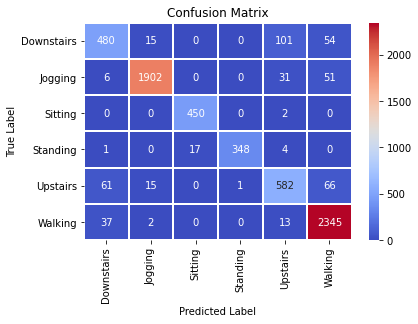


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       650
           1       0.98      0.96      0.97      1990
           2       0.96      1.00      0.98       452
           3       1.00      0.94      0.97       370
           4       0.79      0.80      0.80       725
           5       0.93      0.98      0.95      2397

    accuracy                           0.93      6584
   macro avg       0.92      0.90      0.91      6584
weighted avg       0.93      0.93      0.93      6584



In [31]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_11  (None, 160)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_11 (Dense

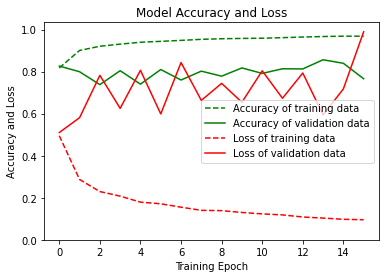

In [34]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 10
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.92

Loss on test data: 0.34

--- Confusion matrix for test data ---



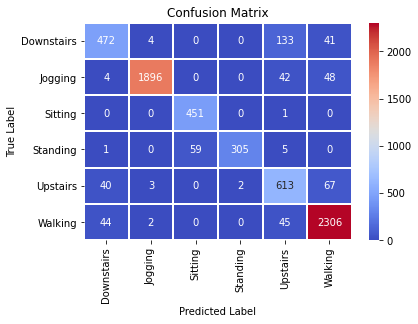


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       650
           1       1.00      0.95      0.97      1990
           2       0.88      1.00      0.94       452
           3       0.99      0.82      0.90       370
           4       0.73      0.85      0.78       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.92      0.92      0.92      6584



In [35]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_12  (None, 160)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_12 (Dense

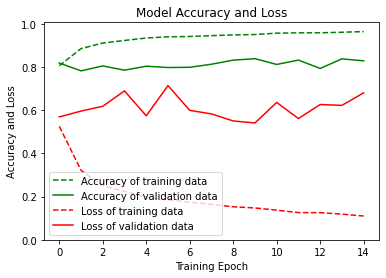

In [36]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 15

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


--- Check against test data ---

6584/6584 [==============================] - 1s 104us/step

Accuracy on test data: 0.92

Loss on test data: 0.38

--- Confusion matrix for test data ---



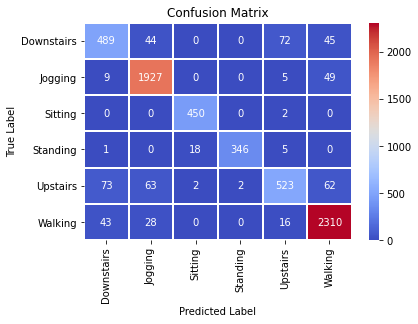


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       650
           1       0.93      0.97      0.95      1990
           2       0.96      1.00      0.98       452
           3       0.99      0.94      0.96       370
           4       0.84      0.72      0.78       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.92      6584
   macro avg       0.91      0.89      0.90      6584
weighted avg       0.92      0.92      0.92      6584



In [37]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_13  (None, 160)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_13 (Dense

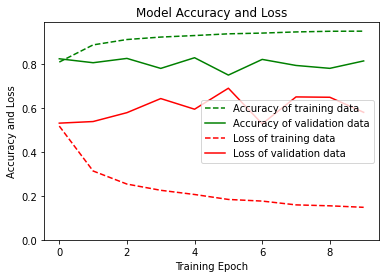

In [38]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


--- Check against test data ---

6584/6584 [==============================] - 1s 80us/step

Accuracy on test data: 0.91

Loss on test data: 0.38

--- Confusion matrix for test data ---



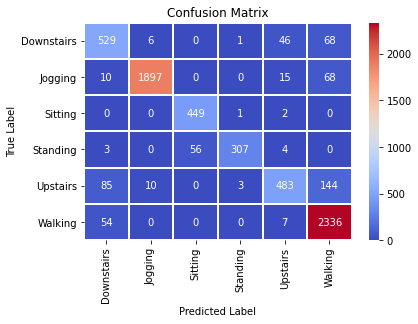


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       650
           1       0.99      0.95      0.97      1990
           2       0.89      0.99      0.94       452
           3       0.98      0.83      0.90       370
           4       0.87      0.67      0.75       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.87      0.88      6584
weighted avg       0.91      0.91      0.91      6584



In [39]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_14  (None, 160)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_14 (Dense

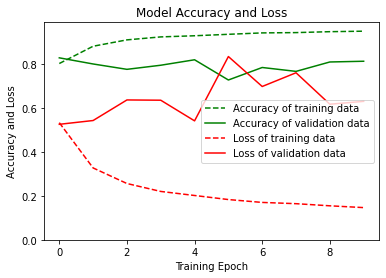

In [40]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


--- Check against test data ---

6584/6584 [==============================] - 0s 72us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



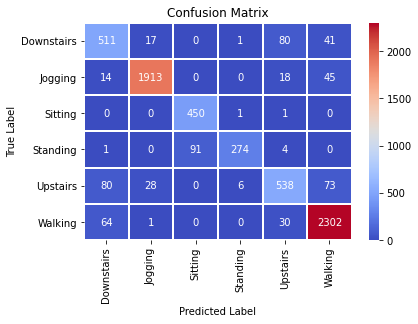


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       650
           1       0.98      0.96      0.97      1990
           2       0.83      1.00      0.91       452
           3       0.97      0.74      0.84       370
           4       0.80      0.74      0.77       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.88      0.86      0.87      6584
weighted avg       0.91      0.91      0.91      6584



In [41]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_16  (None, 160)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_16 (Dense

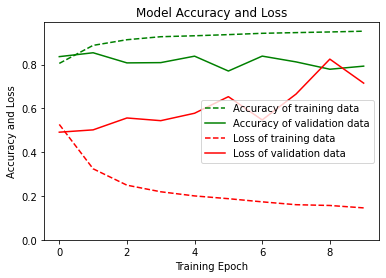


--- Check against test data ---

6584/6584 [==============================] - 1s 171us/step

Accuracy on test data: 0.92

Loss on test data: 0.35

--- Confusion matrix for test data ---



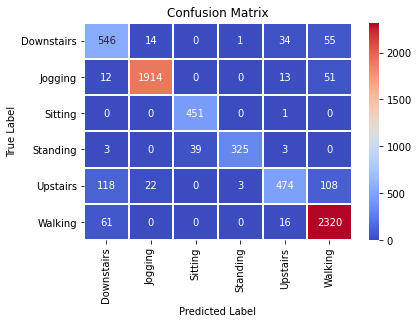


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       650
           1       0.98      0.96      0.97      1990
           2       0.92      1.00      0.96       452
           3       0.99      0.88      0.93       370
           4       0.88      0.65      0.75       725
           5       0.92      0.97      0.94      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.92      0.92      0.91      6584



In [43]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))